In [1]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from Aux2 import *
import NMRAux as nmr
import Layers as ly

from torchinfo import summary

import torch as th
import torch.nn as nn
from torch import Tensor
from torch.utils.data import Dataset,DataLoader
from safetensors.torch import load_model
#from torchvision.models import googlenet

#from collections.abc import Callable
from tqdm.notebook import trange, tqdm

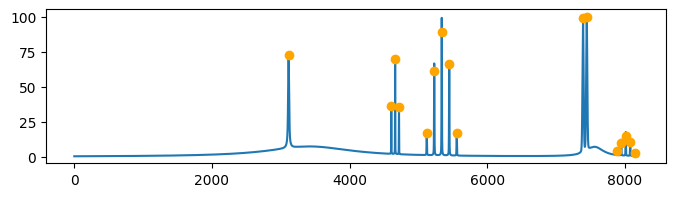

In [53]:
yy, res = nmr.generateRandomSpectrum(16)
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(yy["pure"])
ax.scatter(res,[yy["pure"][i] for i in res], c = "orange", zorder = 10)

In [13]:
ML = 10000
ML_test = 500
batch_size = 1
train_set = NMRDataset(maxLen = ML, mode = "wide")
test_set = NMRDataset(maxLen = ML_test, startSeed = ML)

train_loader: DataLoader = DataLoader(
    dataset=train_set, batch_size=batch_size, shuffle=False,
    num_workers=2
)
test_loader: DataLoader = DataLoader(
    dataset=test_set,  batch_size=batch_size, shuffle=False,
    num_workers=2
)

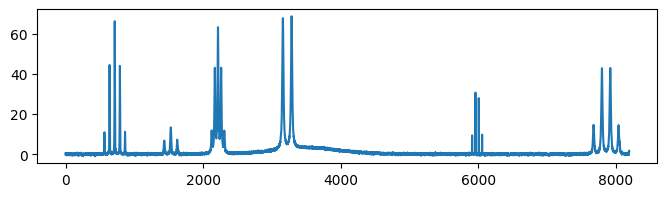

In [4]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(train_set[0][0].T)

In [5]:
# Let's detect and select the most appropriate device
# (adapt it to your specific hardware needs: mps, tpu, ...)
device: th.device = th.device(
    "cuda" if th.cuda.is_available() else "cpu"
)

In [6]:
model: th.nn.Module = NMRSeq().to(device)
summary(model, input_size=(batch_size,1,nmr.nPts))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [512, 1, 8192]            --
├─Inception_variant: 1-1                 [512, 136, 8192]          --
│    └─Inception_piece: 2-1              [512, 16, 8192]           --
│    │    └─Conv1d: 3-1                  [512, 1, 8193]            3
│    │    └─Conv1d: 3-2                  [512, 16, 8192]           48
│    └─Inception_piece: 2-2              [512, 32, 8192]           --
│    │    └─Conv1d: 3-3                  [512, 1, 8195]            5
│    │    └─Conv1d: 3-4                  [512, 32, 8192]           160
│    └─Inception_piece: 2-3              [512, 64, 8192]           --
│    │    └─Conv1d: 3-5                  [512, 1, 8199]            9
│    │    └─Conv1d: 3-6                  [512, 64, 8192]           576
│    └─Inception_piece: 2-4              [512, 16, 8192]           --
│    │    └─Conv1d: 3-7                  [512, 1, 8223]            33
│    │    └─Conv

In [7]:
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=0.001, weight_decay=0
)

#lossCriterion = nn.MSELoss()
lossCriterion = nn.CrossEntropyLoss()

In [8]:
EPOCHS = 100

'''
# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training
    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):
        x, y = batched_datapoint
        x, y = x.to(device), y.to(device)

        # Forward pass + loss computation
        yhat = model(x)
        loss = lossCriterion(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()
'''

'\n# Loop over epochs\nfor epoch in trange(EPOCHS, desc="Training epoch"):\n\n    model.train()  # Remember to set the model in training mode before actual training\n    # Loop over data\n    for batch_idx, batched_datapoint in enumerate(train_loader):\n        x, y = batched_datapoint\n        x, y = x.to(device), y.to(device)\n\n        # Forward pass + loss computation\n        yhat = model(x)\n        loss = lossCriterion(yhat, y)\n\n        # Zero-out past gradients\n        optimizer.zero_grad()\n\n        # Backward pass\n        loss.backward()\n\n        # Update model parameters\n        optimizer.step()\n'

In [9]:
load_model(model, "./modelparspaolo.safetensors")

(set(), set())

In [14]:
dataiter = train_loader.__iter__()
x_a, y_a = dataiter.__next__()

KeyboardInterrupt: 

In [49]:
x_a, y_a = dataiter.__next__()

In [50]:
x_a, y_a = x_a.to(device), y_a.to(device)
target = model(x_a)
k = target.detach().numpy()[0][0]

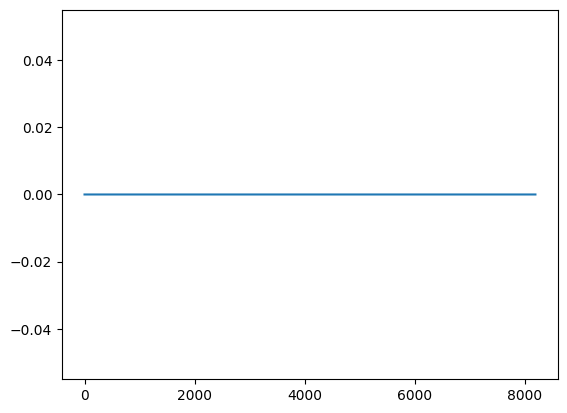

In [51]:
plt.plot(k)

In [13]:
train_set[0][0]

tensor([[0.5135, 0.3831, 0.1265,  ..., 1.8239, 1.4887, 1.5221]])